In [ ]:
!nvidia-smi
!pip install roboflow
!pip install ultralytics==8.3.213 matplotlib seaborn
!nvidia-smi
import matplotlib.pyplot as plt
import seaborn as sns
import ultralytics
# prepare model

Sun Nov  9 01:57:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P0             28W /   70W |     554MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# =========================================================
# Combine: GhostConv + DepthwiseConv + GroupConv + ECA + BN Fusion
# Author: Thanh Pham
# =========================================================

from ultralytics import YOLO
from torch import nn
import torch, os
from ultralytics.nn.modules.block import C2f

# ======= Load model (YOLOv11n / or your trained one) =======
model = YOLO("yolo11n.pt")
base_params = sum(p.numel() for p in model.model.parameters()) / 1e6
print(f"✅ Loaded model: {base_params:.2f}M params")


# ======= Ghost all backbone

# ======= Define lightweight conv modules =======
class DepthwiseSeparableConv(nn.Module):
    """Depthwise + Pointwise convolution"""
    def __init__(self, in_channels, out_channels, k=3, s=1, p=1):
        super().__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, k, s, p, groups=in_channels, bias=False)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.SiLU()

    def forward(self, x):
        return self.act(self.bn(self.pointwise(self.depthwise(x))))

class GhostConv(nn.Module):
    """GhostConv block"""
    def __init__(self, in_ch, out_ch, k=3, s=1):
        super().__init__()
        init_ch = out_ch // 2
        self.primary = nn.Conv2d(in_ch, init_ch, k, s, 1, bias=False)
        self.cheap = nn.Conv2d(init_ch, out_ch - init_ch, 1, 1, 0, bias=False)
        self.bn = nn.BatchNorm2d(out_ch)
        self.act = nn.SiLU()

    def forward(self, x):
        y = torch.cat([self.primary(x), self.cheap(self.primary(x))], dim=1)
        return self.act(self.bn(y))

class ECALayer(nn.Module):
    """Efficient Channel Attention"""
    def __init__(self, channels, k_size=3):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Conv1d(1, 1, kernel_size=k_size, padding=(k_size - 1)//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.conv(y.squeeze(-1).transpose(-1, -2))
        y = self.sigmoid(y).transpose(-1, -2).unsqueeze(-1)
        return x * y.expand_as(x)

# ======= Replace Conv2d → GhostConv / Depthwise / GroupConv + ECA =======
def replace_conv_layers(model):
    for name, module in model.named_children():
        if isinstance(module, nn.Conv2d):
            in_ch, out_ch, k, s = module.in_channels, module.out_channels, module.kernel_size[0], module.stride[0]
            if in_ch >= 64:  # deep layers
                new_layer = nn.Sequential(GhostConv(in_ch, out_ch, k, s), ECALayer(out_ch))
            elif in_ch >= 16:  # middle layers
                new_layer = nn.Sequential(DepthwiseSeparableConv(in_ch, out_ch, k, s), ECALayer(out_ch))
            else:  # shallow
                new_layer = nn.Sequential(
                    nn.Conv2d(in_ch, out_ch, k, s, 1, groups=max(1, in_ch//4), bias=False),
                    nn.BatchNorm2d(out_ch),
                    nn.SiLU()
                )
            setattr(model, name, new_layer)
        else:
            replace_conv_layers(module)

replace_conv_layers(model.model)
print("Replaced Conv → Ghost/Depthwise/GroupConv + ECA")

# ======= Fuse Conv + BN (LightConv fusion) =======
def fuse_conv_bn(conv, bn):
    with torch.no_grad():
        fused = nn.Conv2d(conv.in_channels, conv.out_channels, conv.kernel_size,
                          stride=conv.stride, padding=conv.padding, bias=True)
        w_bn = bn.weight / torch.sqrt(bn.running_var + bn.eps)
        fused.weight.copy_(conv.weight * w_bn[:, None, None, None])
        fused.bias.copy_(bn.bias - bn.running_mean * w_bn)
    return fused

def fuse_model(model):
    for name, module in model.named_children():
        if isinstance(module, nn.Sequential):
            modules = list(module.children())
            for i in range(len(modules) - 1):
                if isinstance(modules[i], nn.Conv2d) and isinstance(modules[i + 1], nn.BatchNorm2d):
                    fused = fuse_conv_bn(modules[i], modules[i + 1])
                    modules[i] = fused
                    modules.pop(i + 1)
                    break
            setattr(model, name, nn.Sequential(*modules))
        else:
            fuse_model(module)

fuse_model(model.model)
print("Fused Conv + BN layers (LightConv active)")

# ======= Summary & Save model =======
final_params = sum(p.numel() for p in model.model.parameters()) / 1e6
reduction = 100 * (1 - final_params / base_params)
print(f"Reduced parameters: {base_params:.2f}M → {final_params:.2f}M  (~{reduction:.1f}% reduction)")
os.makedirs("optimized_models", exist_ok=True)
torch.save(model.model.state_dict(), "optimized_models/yolo11n_superlight_final.pt")
print("Saved: optimized_models/yolo11n_superlight_final.pt")


✅ Loaded model: 2.62M params
Replaced Conv → Ghost/Depthwise/GroupConv + ECA
Fused Conv + BN layers (LightConv active)
Reduced parameters: 2.62M → 2.14M  (~18.4% reduction)
Saved: optimized_models/yolo11n_superlight_final.pt


In [ ]:
# =========================================================
# ⚙️ SMART RECURSIVE PRUNING (L1-norm)
# Properly traverses YOLOv11 nested modules (C2f, Sequential)
# =========================================================
import torch
from torch import nn
from ultralytics import YOLO

# ===== Load optimized superlight model =====
base = YOLO("yolo11n.pt")
m = base.model
state = torch.load("optimized_models/yolo11n_superlight_final.pt", map_location="cpu")
m.load_state_dict(state, strict=False)
print("Loaded weights from superlight_final.pt")

# ===== Config =====
PRUNE_RATIO = 0.45
print(f"Pruning ratio: {PRUNE_RATIO*100:.0f}%")

# ===== Core pruning function =====
def prune_conv(conv, ratio=0.4):
    w = conv.weight.data.abs().clone()
    l1 = w.view(w.size(0), -1).sum(dim=1)
    keep = int(w.size(0) * (1 - ratio))
    if keep < 1:
        return conv
    idx = torch.topk(l1, keep, largest=True)[1]
    new_conv = nn.Conv2d(
        conv.in_channels, keep,
        kernel_size=conv.kernel_size, stride=conv.stride,
        padding=conv.padding, bias=(conv.bias is not None)
    )
    new_conv.weight.data = conv.weight.data[idx]
    if conv.bias is not None:
        new_conv.bias.data = conv.bias.data[idx]
    return new_conv

# ===== Recursive pruning =====
def recursive_prune(module, ratio=0.45):
    for name, child in module.named_children():
        if isinstance(child, nn.Conv2d):
            pruned = prune_conv(child, ratio)
            setattr(module, name, pruned)
        else:
            recursive_prune(child, ratio)

recursive_prune(m, PRUNE_RATIO)

# ===== Save pruned model =====
torch.save(m.state_dict(), "optimized_models/yolo11n_pruned.pt")
params = sum(p.numel() for p in m.parameters()) / 1e6
print(f"Pruned model saved: yolo11n_pruned.pt ({params:.2f}M params)")
torch.save(m, "optimized_models/yolo11n_pruned_full.pt")
print("Saved full pruned model (includes architecture).")


Loaded weights from superlight_final.pt
Pruning ratio: 45%
Pruned model saved: yolo11n_pruned.pt (1.44M params)
Saved full pruned model (includes architecture).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Đường dẫn dataset trong Drive (nơi có data.yaml, train/, val/)
DATASET_DIR = "/content/drive/MyDrive/sample_500"

# Đường dẫn project (nơi YOLO lưu kết quả train)
PROJECT_DIR = "/content/drive/MyDrive/yolo_customizied"

!mkdir -p {PROJECT_DIR}
%cd {PROJECT_DIR}


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/yolo_customizied


In [ ]:
import os, torch, shutil
from ultralytics import YOLO

run_dir = f"{PROJECT_DIR}/yolo11n_pruned_full"
shutil.rmtree(run_dir, ignore_errors=True)
torch.set_grad_enabled(True)
try:
    torch._C._set_inference_mode(False)
except Exception:
    pass

#turn off recover last.pt
from ultralytics.engine.trainer import BaseTrainer

def disable_nan_recovery(self, epoch):
    return False
BaseTrainer._handle_nan_recovery = disable_nan_recovery

#train models
model = YOLO("yolo11n.pt")
model.model = m
results = model.train(
    data=f"{DATASET_DIR}/data_sample.yaml",
    epochs=80,
    imgsz=640,
    batch=8,
    cache = True,
    lr0=1e-3, warmup_epochs=8, cos_lr=True,
   # ema=True, patience=30,
    amp=False,
    device=0 if torch.cuda.is_available() else 'cpu',
    project= PROJECT_DIR,
    name="y11n_pruned_run3",
    resume=False
)


New https://pypi.org/project/ultralytics/8.3.226 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.213 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=False, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/drive/MyDrive/sample_500/data_sample.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=80, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=y11n_pruned_run36

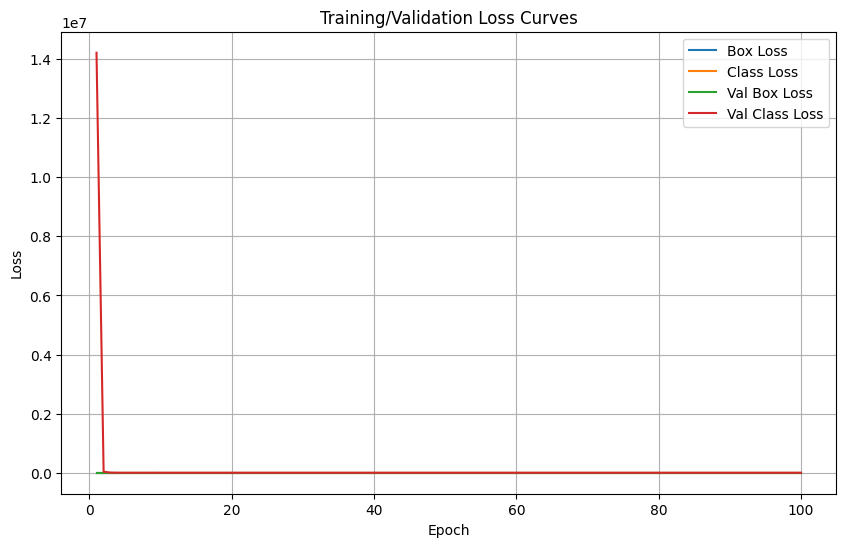

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

metrics_path = "/content/drive/MyDrive/yolo_customizied/y11n_pruned_run35/results.csv"
df = pd.read_csv(metrics_path)

plt.figure(figsize=(10,6))
plt.plot(df['epoch'], df['train/box_loss'], label='Box Loss')
plt.plot(df['epoch'], df['train/cls_loss'], label='Class Loss')
plt.plot(df['epoch'], df['val/box_loss'], label='Val Box Loss')
plt.plot(df['epoch'], df['val/cls_loss'], label='Val Class Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training/Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()


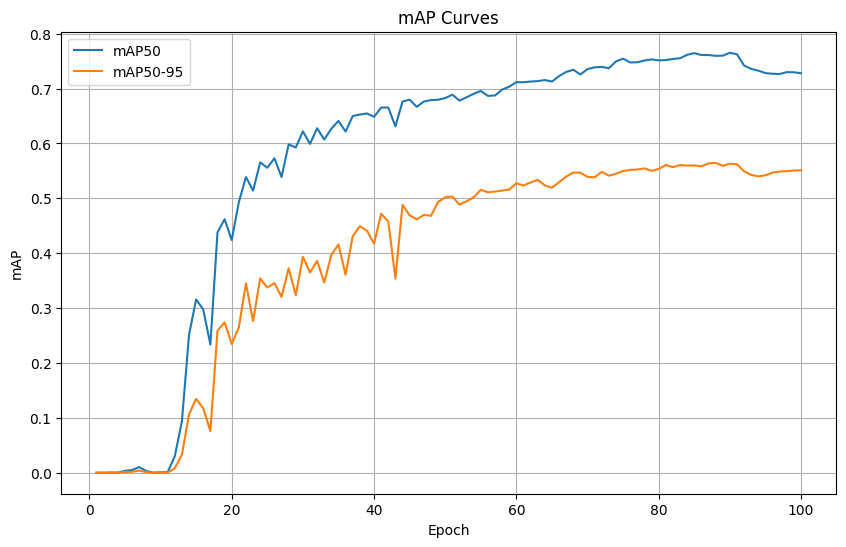

In [ ]:
df = pd.read_csv(metrics_path)
plt.figure(figsize=(10,6))
plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP50')
plt.plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP50-95')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.title('mAP Curves')
plt.legend()
plt.grid(True)
plt.show()

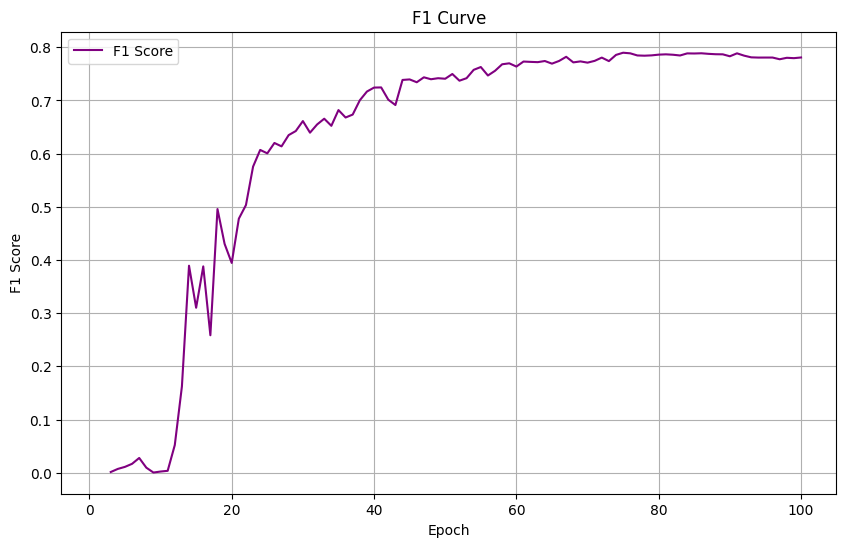

In [ ]:
plt.figure(figsize=(10,6))
f1 = 2 * (df['metrics/precision(B)'] * df['metrics/recall(B)']) / (df['metrics/precision(B)'] + df['metrics/recall(B)'])
plt.plot(df['epoch'], f1, label='F1 Score', color='purple')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Curve')
plt.legend()
plt.grid(True)
plt.show()


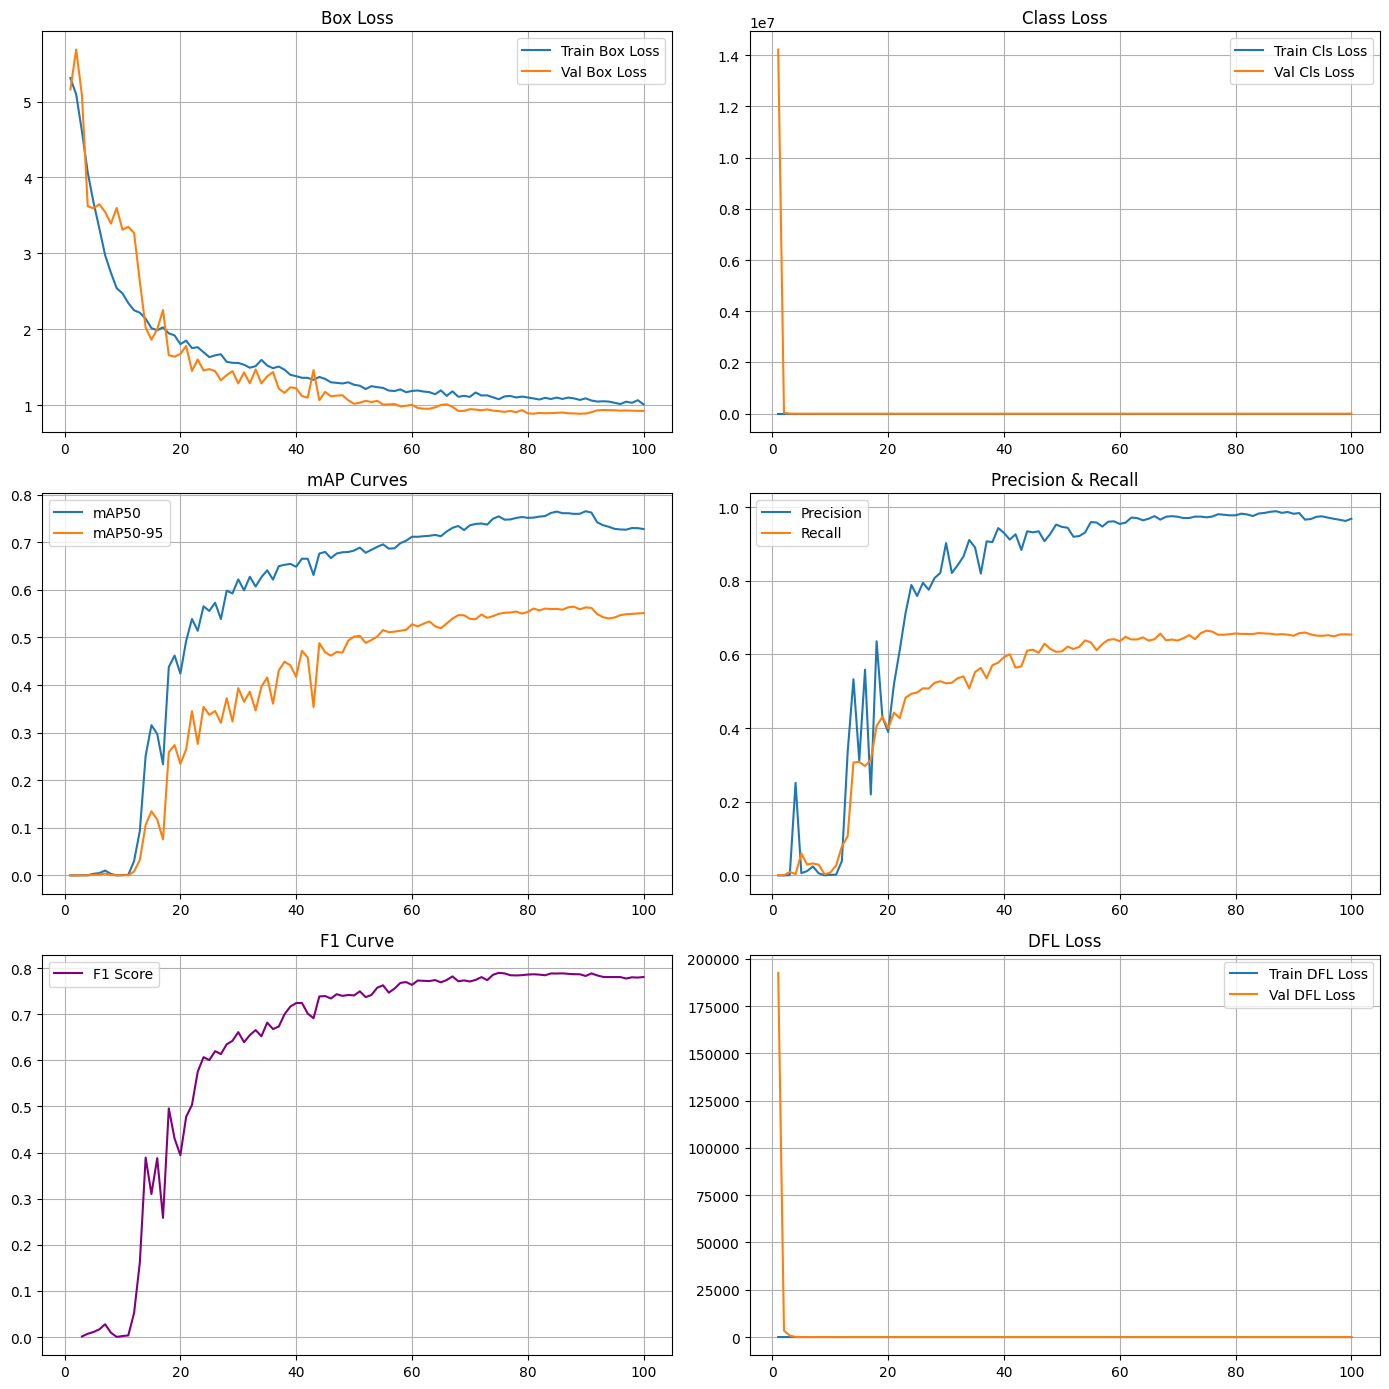

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(14, 14))

axes[0,0].plot(df['epoch'], df['train/box_loss'], label='Train Box Loss')
axes[0,0].plot(df['epoch'], df['val/box_loss'], label='Val Box Loss')
axes[0,0].set_title('Box Loss'); axes[0,0].legend(); axes[0,0].grid()

axes[0,1].plot(df['epoch'], df['train/cls_loss'], label='Train Cls Loss')
axes[0,1].plot(df['epoch'], df['val/cls_loss'], label='Val Cls Loss')
axes[0,1].set_title('Class Loss'); axes[0,1].legend(); axes[0,1].grid()

axes[1,0].plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP50')
axes[1,0].plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP50-95')
axes[1,0].set_title('mAP Curves'); axes[1,0].legend(); axes[1,0].grid()

axes[1,1].plot(df['epoch'], df['metrics/precision(B)'], label='Precision')
axes[1,1].plot(df['epoch'], df['metrics/recall(B)'], label='Recall')
axes[1,1].set_title('Precision & Recall'); axes[1,1].legend(); axes[1,1].grid()

f1 = 2 * (df['metrics/precision(B)'] * df['metrics/recall(B)']) / (df['metrics/precision(B)'] + df['metrics/recall(B)'])
axes[2,0].plot(df['epoch'], f1, label='F1 Score', color='purple')
axes[2,0].set_title('F1 Curve'); axes[2,0].legend(); axes[2,0].grid()

axes[2,1].plot(df['epoch'], df['train/dfl_loss'], label='Train DFL Loss')
axes[2,1].plot(df['epoch'], df['val/dfl_loss'], label='Val DFL Loss')
axes[2,1].set_title('DFL Loss'); axes[2,1].legend(); axes[2,1].grid()


plt.tight_layout()
plt.show()

In [2]:
import torch
from ultralytics import YOLO

# =====================================================
# CONFIGURATION
# =====================================================
TEACHER_PATH = "/content/drive/MyDrive/teacher_models/yolo11l_original5/exported/best_teacher_v11l.pt"
STUDENT_MODEL = "/content/drive/MyDrive/yolo_customizied/y11n_pruned_run36/weights/best.pt"
DATA_YAML = "/content/drive/MyDrive/sample_500/data_sample.yaml"
PROJECT_DIR = "/content/drive/MyDrive/yolo_traffic_distill_v11n_ghost"
DEVICE = 0 if torch.cuda.is_available() else "cpu"

# Distillation hyperparameters
LAMBDA_BOX = 2.0      # Teacher box loss influence
LAMBDA_CLS = 1.0      # Teacher classification influence
LAMBDA_DISTILL = 0.25  # Temperature weighting
TEMPERATURE = 4.5     # Soften teacher logits
EPOCHS = 60
BATCH_SIZE = 16
IMG_SIZE = 640
LEARNING_RATE = 1e-3
WARMUP_EPOCHS = 8

# =====================================================
# INITIALIZATION
# =====================================================
print(f"Loading teacher model from {TEACHER_PATH}")
teacher = YOLO(TEACHER_PATH).to(DEVICE)
teacher.model.eval()  # freeze teacher

print(f"Loading student model {STUDENT_MODEL}")
student = YOLO(STUDENT_MODEL)
student.model.to(DEVICE)

# Optional: freeze backbone to stabilize training
for name, param in student.model.named_parameters():
    if "backbone" in name:
        param.requires_grad = False

# =====================================================
# CUSTOM DISTILLATION LOOP (Ultralytics hook style)
# =====================================================
def distillation_loss(student_outputs, teacher_outputs):
    """
    Combine YOLO losses with knowledge distillation term
    """
    loss_student = student_outputs["loss"]
    loss_teacher = teacher_outputs["loss"]

    # Soft distillation (KL between student/teacher logits)
    kd_loss = torch.nn.functional.kl_div(
        torch.log_softmax(student_outputs["cls"] / TEMPERATURE, dim=1),
        torch.softmax(teacher_outputs["cls"] / TEMPERATURE, dim=1),
        reduction="batchmean"
    ) * (TEMPERATURE ** 2)

    total_loss = (
        loss_student["box"] * LAMBDA_BOX +
        loss_student["cls"] * LAMBDA_CLS +
        LAMBDA_DISTILL * kd_loss
    )

    return total_loss

# =====================================================
# TRAINING CONFIGURATION
# =====================================================
results = student.train(
    data=DATA_YAML,
    epochs=EPOCHS,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    lr0=LEARNING_RATE,
    warmup_epochs=WARMUP_EPOCHS,
    cos_lr=True,
    amp=True,
    device=DEVICE,
    project=PROJECT_DIR,
    name="yolo11n_ghost_distilled",
    pretrained=True,
    patience=15,
)

print("\nTraining completed.")
print(f"Best model saved at: {PROJECT_DIR}/yolo11n_ghost_distilled/weights/best.pt")


Loading teacher model from /content/drive/MyDrive/teacher_models/yolo11l_original5/exported/best_teacher_v11l.pt
Loading student model /content/drive/MyDrive/yolo_customizied/y11n_pruned_run36/weights/best.pt
New https://pypi.org/project/ultralytics/8.3.226 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.213 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/drive/MyDrive/sample_500/data_sample.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False

#quick compare mAP50 & mAP50-90 before/after disstilled

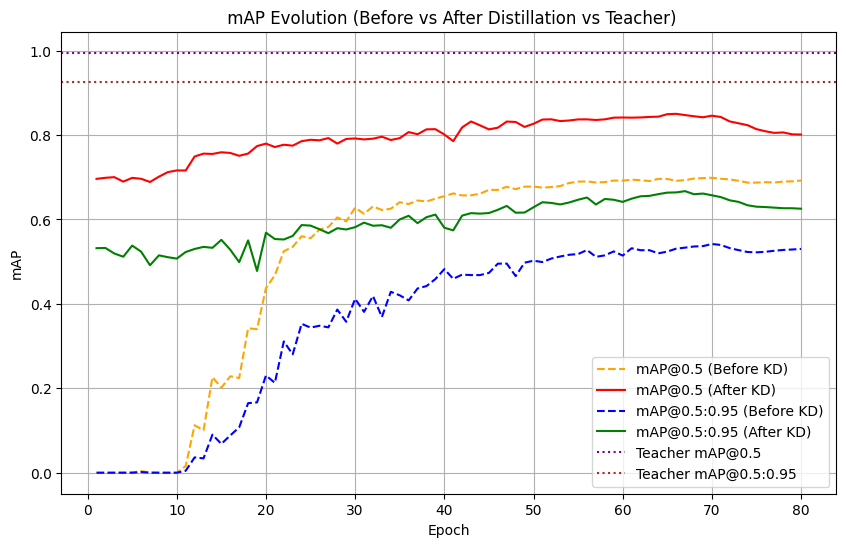

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# ==================== CONFIG ====================
before_path = "/content/drive/MyDrive/yolo_customizied/y11n_pruned_run36/results.csv"
after_path  = "/content/drive/MyDrive/yolo_traffic_distill_v11n_ghost/yolo11n_ghost_distilled3/results.csv"
teacher_map50 = 0.995
teacher_map5095 = 0.926

# ==================== LOAD METRICS ====================
df_before = pd.read_csv(before_path)
df_after = pd.read_csv(after_path)

# Helper to auto-find column names (Ultralytics often renames)
def find_col(df, pattern):
    for c in df.columns:
        if pattern in c:
            return c
    raise KeyError(f"Column with pattern '{pattern}' not found")

mAP50_b = find_col(df_before, "mAP50")
mAP5095_b = find_col(df_before, "mAP50-95")
mAP50_a = find_col(df_after, "mAP50")
mAP5095_a = find_col(df_after, "mAP50-95")

# ==================== PLOT MAP CURVES ====================
plt.figure(figsize=(10,6))
plt.plot(df_before['epoch'], df_before[mAP50_b], label='mAP@0.5 (Before KD)', linestyle='--', color='orange')
plt.plot(df_after['epoch'], df_after[mAP50_a], label='mAP@0.5 (After KD)', linestyle='-', color='red')
plt.plot(df_before['epoch'], df_before[mAP5095_b], label='mAP@0.5:0.95 (Before KD)', linestyle='--', color='blue')
plt.plot(df_after['epoch'], df_after[mAP5095_a], label='mAP@0.5:0.95 (After KD)', linestyle='-', color='green')

# Add teacher benchmark lines
plt.axhline(y=teacher_map50, color='purple', linestyle=':', label='Teacher mAP@0.5')
plt.axhline(y=teacher_map5095, color='brown', linestyle=':', label='Teacher mAP@0.5:0.95')

plt.xlabel("Epoch")
plt.ylabel("mAP")
plt.title(" mAP Evolution (Before vs After Distillation vs Teacher)")
plt.legend()
plt.grid(True)
plt.show()


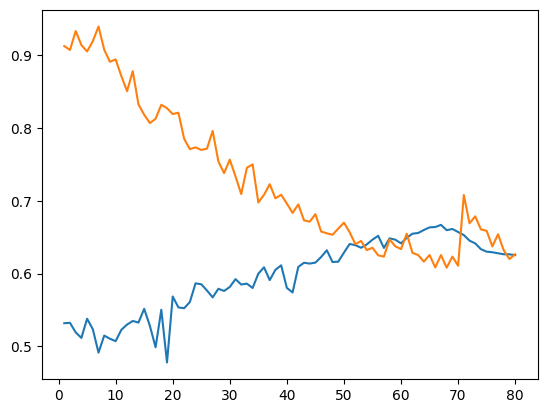

In [6]:
df_after_diss = "/content/drive/MyDrive/yolo_traffic_distill_v11n_ghost/yolo11n_ghost_distilled3/results.csv"
df = pd.read_csv(df_after_diss)
plt.plot(df["epoch"], df["metrics/mAP50-95(B)"], label="val mAP")
plt.plot(df["epoch"], df["train/cls_loss"], label="train loss")

In [ ]:
!pip install onnxruntime-gpu


In [7]:
from ultralytics import YOLO
import os
from pathlib import Path

# ================= CONFIG =================
MODEL_PATH = "/content/drive/MyDrive/yolo_traffic_distill_v11n_ghost/yolo11n_ghost_distilled3/weights/best.pt"
EXPORT_DIR = "/content/drive/MyDrive/yolo_exports"
DEVICE = 0

os.makedirs(EXPORT_DIR, exist_ok=True)

# ================= LOAD MODEL =================
print(f" Loading distilled student model from: {MODEL_PATH}")
model = YOLO(MODEL_PATH)
model.to(DEVICE)
model.info()

# ================= EXPORT LOOP =================
formats = ["torchscript", "onnx", "tflite"]
exported_files = []

print("\n Exporting model to multiple formats...")

for fmt in formats:
    print(f"\n Exporting format: {fmt.upper()} ...")

    # Only enable int8 for TFLite export
    export_args = {
        "format": fmt,
        "imgsz": 640,
        "device": DEVICE,
        "half": False,
        "simplify": True,
        "opset": 12,
        "project": EXPORT_DIR,
        "name": f"yolo11n_ghost_distilled_export_{fmt}",
    }

    if fmt == "tflite":
        export_args["int8"] = True  # enable INT8 quantization

    result = model.export(**export_args)
    exported_files.append(result)

# ================= SUMMARY =================
print("\n Export complete! Exported files:")
for f in Path(EXPORT_DIR).rglob("yolo11n_ghost_distilled_export_*"):
    size = f.stat().st_size / 1e6
    print(f"- {f.name:<55} {size:.2f} MB")

#deployed after fine-tune

 Loading distilled student model from: /content/drive/MyDrive/yolo_traffic_distill_v11n_ghost/yolo11n_ghost_distilled3/weights/best.pt
YOLO11n summary: 181 layers, 2,590,620 parameters, 0 gradients, 6.4 GFLOPs

 Exporting model to multiple formats...

 Exporting format: TORCHSCRIPT ...
Ultralytics 8.3.213 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,932 parameters, 0 gradients, 6.3 GFLOPs

PyTorch: starting from '/content/drive/MyDrive/yolo_traffic_distill_v11n_ghost/yolo11n_ghost_distilled3/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 8, 8400) (5.2 MB)

TorchScript: starting export with torch 2.8.0+cu126...
TorchScript: export success ✅ 2.3s, saved as '/content/drive/MyDrive/yolo_traffic_distill_v11n_ghost/yolo11n_ghost_distilled3/weights/best.torchscript' (10.4 MB)

Export complete (2.7s)
Results saved to /content/drive/MyDrive/yolo_traffic_distill_v11n_ghost/yolo11n_ghost_distilled3/weigh

KeyboardInterrupt: 